# Customer Segmentation

In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Load the data

In [10]:
data = pd.read_csv('./data/Mall_Customers.csv', index_col=0)

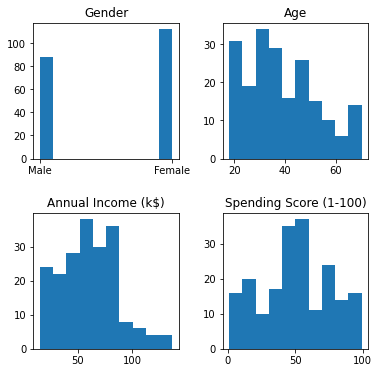

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (6,6))
fig.subplots_adjust(hspace = 0.4, wspace = 0.3)
for i in range(data.shape[1]):
    ax = axes.flat[i]
    ax.hist(data.iloc[:,i])
    ax.set_title(data.columns[i])

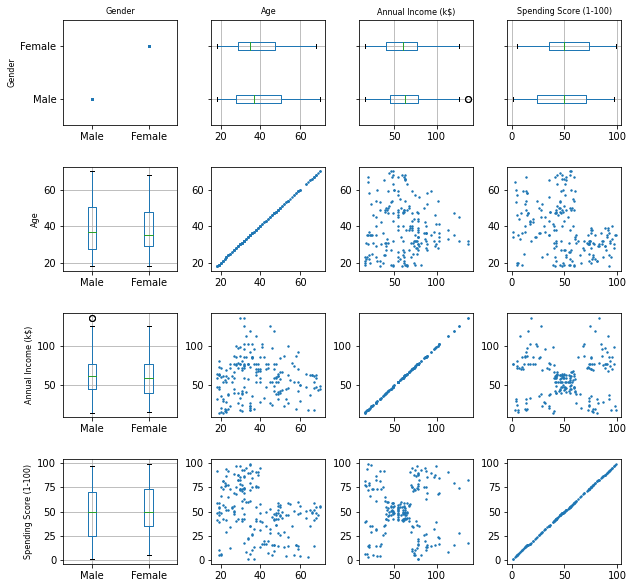

In [54]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (10,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.3)
for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        ax = axes[j,i]
        if (i == j) and (i == 0) and (j == 0):
            ax.scatter(data.iloc[:,i], data.iloc[:,j], s = 2)
            ax.set_xlim([-0.5,1.5])
            ax.set_ylim([-0.5,1.5])
        elif (i == 0):
            ordering = enumerate(data.iloc[:,i].unique())
            positions = [ind for val, ind in sorted((v, i) for (i, v) in ordering)]
            data.iloc[:,[j]].groupby(data.iloc[:,i]).boxplot(subplots=False, ax = ax,
                                                             positions = positions)            
            ax.set_xticklabels(['Female','Male'])
        elif (j == 0):
            ordering = enumerate(data.iloc[:,j].unique())
            positions = [ind for val, ind in sorted((v, i) for (i, v) in ordering)]
            data.iloc[:,[i]].groupby(data.iloc[:,j]).boxplot(subplots=False,
                vert = False, ax = ax, positions = positions)
            ax.set_yticklabels([])
        else:
            ax.scatter(data.iloc[:,i], data.iloc[:,j], s = 2)

        if i == 0:
            ax.set_ylabel(data.columns[j], fontsize = 8)
        if j == 0:
            ax.set_title(data.columns[i], fontsize = 8)

## 1. KMeans

Text(0, 0.5, 'Inertia')

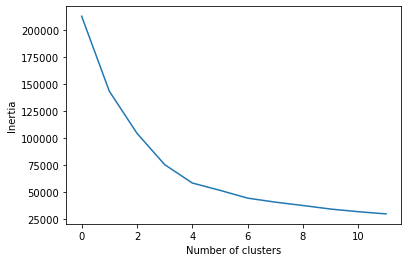

In [112]:
np.random.seed(42)

# Replace the male & female by 0,1
X = data.copy(deep = True)
X['Gender'] = X['Gender'] == 'Female'

inertia_list = []
for i in range(12):
    mod = KMeans(n_clusters = i+2).fit(X)
    inertia_list.append(mod.inertia_)

fig, ax = plt.subplots()
ax.plot(range(len(inertia_list)), inertia_list)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')

In [113]:
mod = KMeans(n_clusters = 5).fit(X)
X['Label'] = mod.labels_
X['Gender'] = data['Gender']

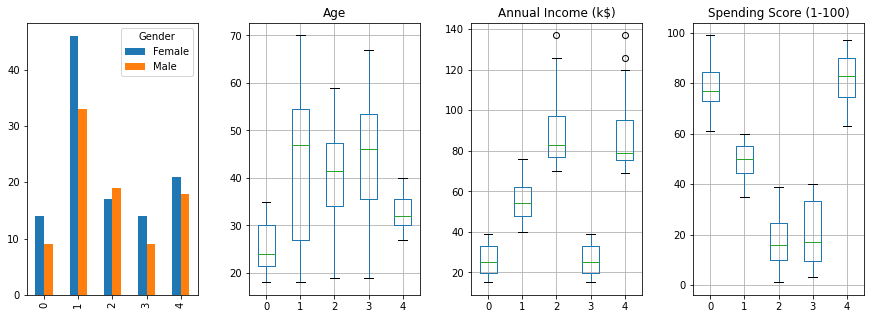

In [121]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (15,5))
fig.subplots_adjust(hspace = 0.4, wspace = 0.3)
for i in range(X.drop('Label', axis = 1).shape[1]):
    ax = axes.flat[i]
    if i == 0:
        X.groupby(['Gender','Label']).count()['Age'].unstack().T.plot.bar(ax = ax)
        ax.set_xlabel('')
    else:
        X.iloc[:,[i]].groupby(X['Label']).boxplot(subplots=False, ax = ax)
        ax.set_xticklabels(range(5))
        ax.set_title(X.columns[i])

## 2. Hierarchical clustering

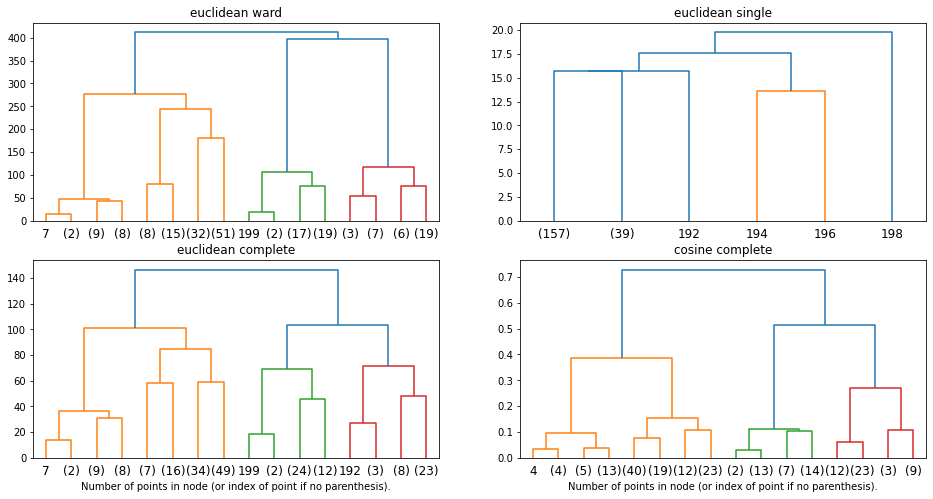

In [156]:
np.random.seed(42)


# Replace the male & female by 0,1
X = data.copy(deep = True)
X['Gender'] = (X['Gender'] == 'Female').astype(int)


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16,8))
count = 0
for j, link in enumerate(['ward', 'single', 'complete']):
    if link == 'ward':
        aff_list = ['euclidean']
    elif link == 'single':
        aff_list = ['euclidean']
    else:
        aff_list = ['euclidean','cosine']

    for i, aff in enumerate(aff_list):
        ax = axes.flat[count]

        mod = AgglomerativeClustering(distance_threshold=0, n_clusters = None, 
                                      affinity = aff, linkage = link).fit(X)
        plot_dendrogram(mod, truncate_mode="level", p=3, ax = ax)
        ax.set_title(aff + ' ' + link)
        if count >= 2:
            ax.set_xlabel("Number of points in node (or index of point if no parenthesis).")
        count += 1

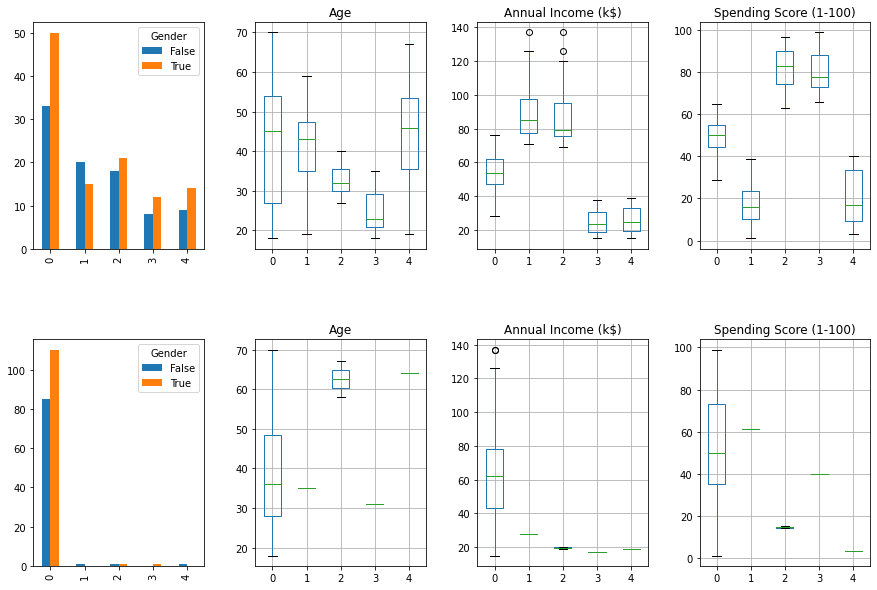

In [161]:
# Use the same number of clusters as KMeans
X = data.copy(deep = True)
X['Gender'] = X['Gender'] == 'Female'

fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (15,10))
fig.subplots_adjust(hspace = 0.4, wspace = 0.3)
for j,aff in enumerate(['euclidean','cosine']):
    if aff == 'euclidean':
        link = 'ward'
    else:
        link = 'single'
    mod = AgglomerativeClustering(n_clusters = 5, affinity = aff, linkage = link).fit(X)
    X['Label'] = mod.labels_

    for i in range(X.drop('Label', axis = 1).shape[1]):
        ax = axes[j,i]
        if i == 0:
            X.groupby(['Gender','Label']).count()['Age'].unstack().T.plot.bar(ax = ax)
            ax.set_xlabel('')
        else:
            X.iloc[:,[i]].groupby(X['Label']).boxplot(subplots=False, ax = ax)
            ax.set_xticklabels(range(5))
            ax.set_title(X.columns[i])